# Plotting polygons with Folium
This example demonstrates how to plot polygons on a Folium map.

In [1]:
import geopandas as gpd
import geodatasets
import folium
import matplotlib.pyplot as plt

## Load geometries
This example uses the nybb dataset, which contains polygons of New York boroughs.

In [2]:
path = geodatasets.get_path("nybb")
df = gpd.read_file(path)
df.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


Plot from the original dataset

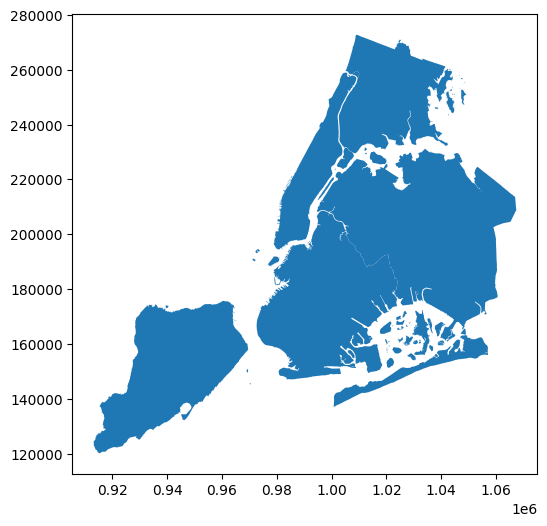

In [3]:
df.plot(figsize=(6, 6))
plt.show()

Notice that the values of the polygon geometries do not directly represent the values of latitude or longitude in a geographic coordinate system.
To view the coordinate reference system of the geometry column, access the `crs` attribute:

In [4]:
df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The [epsg:2263](https://epsg.io/2263) crs is a projected coordinate reference system with linear units (ft in this case).
As folium (i.e. leaflet.js) by default accepts values of latitude and longitude (angular units) as input, we need to project the geometry to a geographic coordinate system first.

In [5]:
# Use WGS 84 (epsg:4326) as the geographic coordinate system
df = df.to_crs(epsg=4326)
print(df.crs)
df.head()

EPSG:4326


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


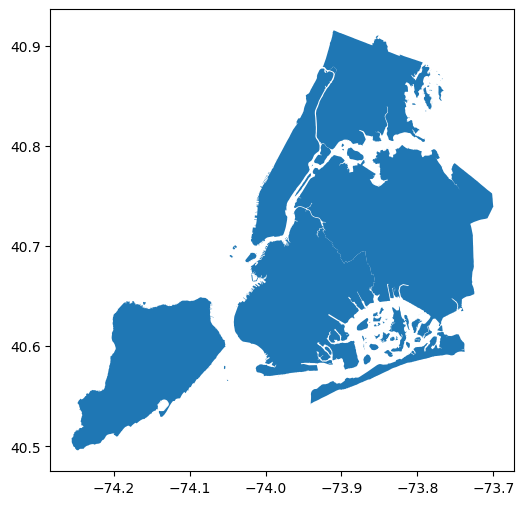

In [6]:
df.plot(figsize=(6, 6))
plt.show()

## Create Folium map

In [7]:
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles="CartoDB positron")
m

### Add polygons to map
Overlay the boundaries of boroughs on map with borough name as popup:

In [8]:
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["BoroName"]).add_to(geo_j)
    geo_j.add_to(m)
m

### Add centroid markers
In order to properly compute geometric properties, in this case centroids, of the geometries, we need to project the data to a projected coordinate system.

In [9]:
# Project to NAD83 projected crs
df = df.to_crs(epsg=2263)

# Access the centroid attribute of each polygon
df["centroid"] = df.centroid

Since we're again adding a new geometry to the Folium map, we need to project the geometry back to a geographic coordinate system with latitude and longitude values.

In [10]:
# Project to WGS84 geographic crs

# geometry (active) column
df = df.to_crs(epsg=4326)

# Centroid column
df["centroid"] = df["centroid"].to_crs(epsg=4326)

df.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,centroid
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",POINT (-74.15340 40.58085)
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...",POINT (-73.81847 40.70757)
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",POINT (-73.94768 40.64472)
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",POINT (-73.96719 40.77725)
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",POINT (-73.86653 40.85262)


In [11]:
for _, r in df.iterrows():
    lat = r["centroid"].y
    lon = r["centroid"].x
    folium.Marker(
        location=[lat, lon],
        popup="length: {} <br> area: {}".format(r["Shape_Leng"], r["Shape_Area"]),
    ).add_to(m)

m